In [ ]:
!pip install deepinv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.6/807.6 kB 18.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 50.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 63.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 84.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 20.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 [deepinv]1/12 [deepinv]rics]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import os
import time

# ----------------------------
# Simple UNet for MNIST Diffusion
# ----------------------------
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, hidden_dim=32):
        super().__init__()
        # Encoder
        self.enc1 = nn.Conv2d(in_channels, hidden_dim, 3, padding=1)          # 32
        self.enc2 = nn.Conv2d(hidden_dim, hidden_dim * 2, 3, padding=1)       # 64
        self.enc3 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 3, padding=1)   # 128

        # Bottleneck
        self.bottleneck = nn.Conv2d(hidden_dim * 4, hidden_dim * 4, 3, padding=1)  # 128

        # Decoder — FIX: input channels = upsampled + skip
        self.dec3 = nn.Conv2d(hidden_dim * 4 + hidden_dim * 2, hidden_dim * 2, 3, padding=1)  # 128+64=192 → 64
        self.dec2 = nn.Conv2d(hidden_dim * 2 + hidden_dim, hidden_dim, 3, padding=1)          # 64+32=96 → 32
        self.dec1 = nn.Conv2d(hidden_dim + in_channels, out_channels, 3, padding=1)           # 32+1=33 → 1

        # Timestep embedding
        self.temb = nn.Linear(1, hidden_dim * 4)  # [B, 128]

    def forward(self, x, t, type_t="timestep"):
        # Process timestep
        if t.dim() > 1:
            t = t.squeeze()
        t = t.float().view(-1, 1)
        t_emb = self.temb(t).unsqueeze(-1).unsqueeze(-1)  # [B, 128, 1, 1]

        # Encoder
        e1 = F.relu(self.enc1(x))                     # [B, 32, 32, 32]
        e2 = F.relu(self.enc2(F.avg_pool2d(e1, 2)))   # [B, 64, 16, 16]
        e3 = F.relu(self.enc3(F.avg_pool2d(e2, 2)))   # [B, 128, 8, 8]

        # Bottleneck + timestep
        b = F.relu(self.bottleneck(e3) + t_emb)       # [B, 128, 8, 8]

        # Decoder
        d3 = F.interpolate(b, scale_factor=2, mode="nearest")    # [B, 128, 16, 16]
        d3 = F.relu(self.dec3(torch.cat([d3, e2], dim=1)))      # [B, 64, 16, 16]

        d2 = F.interpolate(d3, scale_factor=2, mode="nearest")   # [B, 64, 32, 32]
        d2 = F.relu(self.dec2(torch.cat([d2, e1], dim=1)))      # [B, 32, 32, 32]

        # Final output (option: skip connection from input)
        out = self.dec1(torch.cat([d2, x], dim=1))               # [B, 1, 32, 32]
        return out

In [ ]:
# ----------------------------
# Setup
# ----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}\n")

# Hyperparameters
batch_size = 128
image_size = 32
lr = 1e-3
epochs = 50
timesteps = 500
beta_start = 1e-4
beta_end = 0.02

# Data
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,)),
])

print("Loading MNIST dataset...")
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data", train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True,
)
print(f"Dataset loaded. Batches per epoch: {len(train_loader)}\n")

# Model, optimizer, loss
model = SimpleUNet(in_channels=1, out_channels=1, hidden_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()

# Precompute noise schedule
betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

# Print model size
num_params = sum(p.numel() for p in model.parameters())
print(f"Model: SimpleUNet | Parameters: {num_params:,}\n")

Using device: cuda

Loading MNIST dataset...


100%|██████████| 9.91M/9.91M [00:00<00:00, 115MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 3.87MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 38.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.66MB/s]


Dataset loaded. Batches per epoch: 469

Model: SimpleUNet | Parameters: 379,146



In [ ]:
# ----------------------------
# Training Loop
# ----------------------------
print("Starting training...\n")
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    model.train()
    total_loss = 0.0
    num_batches = len(train_loader)

    for data, _ in train_loader:
        imgs = data.to(device)
        noise = torch.randn_like(imgs)
        t = torch.randint(0, timesteps, (imgs.size(0),), device=device)

        # Add noise
        noised_imgs = (
            sqrt_alphas_cumprod[t, None, None, None] * imgs
            + sqrt_one_minus_alphas_cumprod[t, None, None, None] * noise
        )

        optimizer.zero_grad()
        predicted_noise = model(noised_imgs, t)
        loss = mse(predicted_noise, noise)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    epoch_time = time.time() - epoch_start_time
    total_elapsed = time.time() - total_start_time

    print(f"Epoch {epoch + 1}/{epochs} | "
          f"Avg Loss: {avg_loss:.6f} | "
          f"Epoch Time: {epoch_time:.2f}s | "
          f"Total Time: {total_elapsed:.2f}s")

# ----------------------------
# Save Model
# ----------------------------
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/simple_diffusion_model.pth")
print("\nTraining finished!")
print("Model saved to models/simple_diffusion_model.pth")

Starting training...

Epoch 1/50 | Avg Loss: 5.721812 | Epoch Time: 7.57s | Total Time: 7.57s
Epoch 2/50 | Avg Loss: 0.087014 | Epoch Time: 7.21s | Total Time: 14.77s
Epoch 3/50 | Avg Loss: 0.060981 | Epoch Time: 7.16s | Total Time: 21.93s
Epoch 4/50 | Avg Loss: 0.050599 | Epoch Time: 7.12s | Total Time: 29.06s
Epoch 5/50 | Avg Loss: 0.043969 | Epoch Time: 7.10s | Total Time: 36.16s
Epoch 6/50 | Avg Loss: 0.041198 | Epoch Time: 7.19s | Total Time: 43.35s
Epoch 7/50 | Avg Loss: 0.038172 | Epoch Time: 7.12s | Total Time: 50.47s
Epoch 8/50 | Avg Loss: 0.036446 | Epoch Time: 7.06s | Total Time: 57.53s
Epoch 9/50 | Avg Loss: 0.035987 | Epoch Time: 7.02s | Total Time: 64.55s
Epoch 10/50 | Avg Loss: 0.034508 | Epoch Time: 7.05s | Total Time: 71.60s
Epoch 11/50 | Avg Loss: 0.032873 | Epoch Time: 7.05s | Total Time: 78.65s
Epoch 12/50 | Avg Loss: 0.032067 | Epoch Time: 7.08s | Total Time: 85.73s
Epoch 13/50 | Avg Loss: 0.031342 | Epoch Time: 7.06s | Total Time: 92.79s
Epoch 14/50 | Avg Loss: 0.

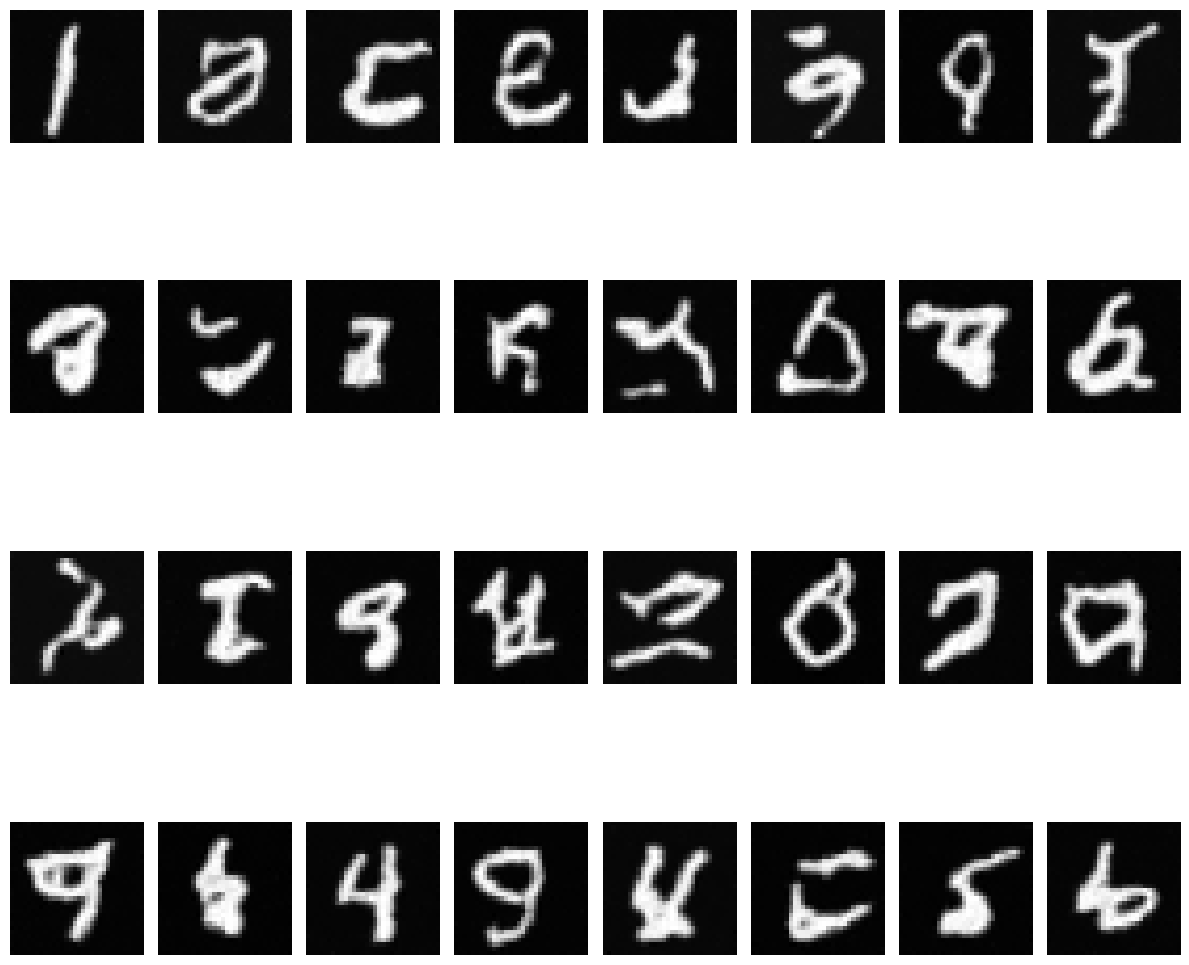

Generated 32 new MNIST-like digits!


In [ ]:
# ----------------------------
# Sampling generation
# ----------------------------

model.eval()
num_samples = 32
img_size = 32

# Start with pure noise
x_t = torch.randn(num_samples, 1, img_size, img_size, device=device)

with torch.no_grad():
    for t in reversed(range(timesteps)):
        t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)

        # Predict noise ε_θ(x_t, t)
        predicted_noise = model(x_t, t_batch)

        # Compute mean and variance for reverse step
        alpha_t = alphas[t]
        alpha_bar_t = alphas_cumprod[t]
        alpha_bar_t_prev = alphas_cumprod[t-1] if t > 0 else torch.tensor(1.0, device=device)
        beta_t = betas[t]

        # Denoise: x_{t-1} = 1/sqrt(alpha_t) * (x_t - beta_t/sqrt(1-alpha_bar_t) * predicted_noise) + sigma_t * z
        x_0_pred = (x_t - sqrt_one_minus_alphas_cumprod[t] * predicted_noise) / sqrt_alphas_cumprod[t]
        x_0_pred = torch.clamp(x_0_pred, -1, 1)  # Clip to [-1,1] for stability

        mean = x_t - ((beta_t * predicted_noise) / (sqrt_one_minus_alphas_cumprod[t]))
        mean = mean / torch.sqrt(alpha_t)

        if t == 0:
            x_t = x_0_pred
        else:
            variance = (1 - alpha_bar_t_prev) / (1 - alpha_bar_t)
            variance = variance * beta_t
            sigma_t = variance ** 0.5
            z = torch.randn_like(x_t)  # same shape & device as x_t
            x_t = mean + sigma_t * z   # only a single tensor, no tuple


# Post-process: convert to [0,1] and detach
generated_images = (x_t.clamp(-1, 1) + 1) / 2.0  # From [-1,1] to [0,1]

# Plot generated images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 8, figsize=(12, 12))
axes = axes.flatten()

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(generated_images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Generated 32 new MNIST-like digits!")

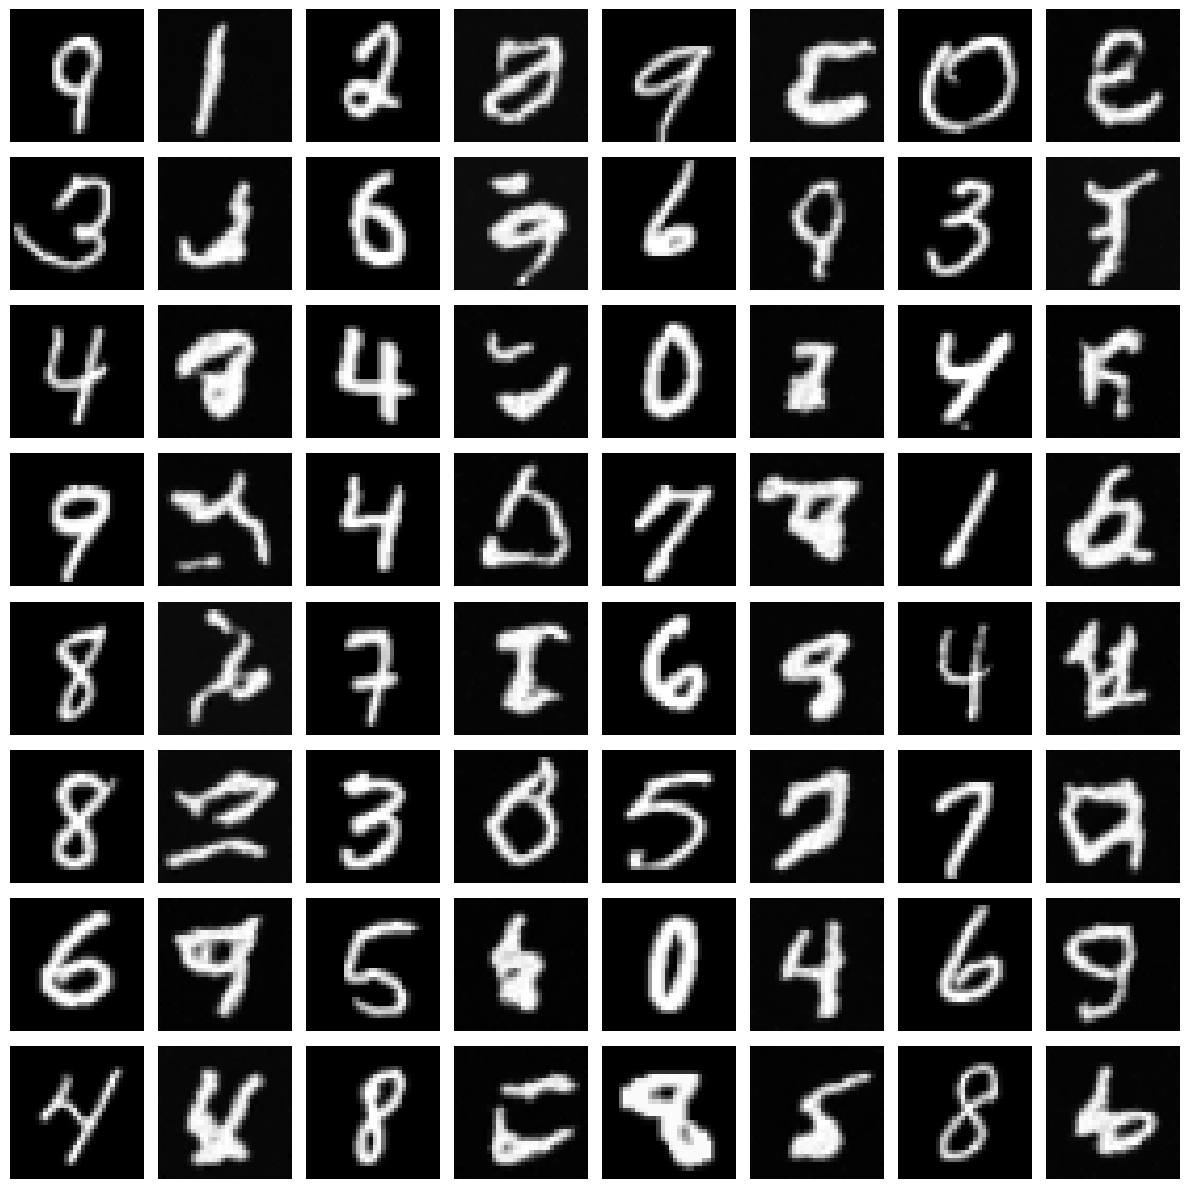

In [ ]:
# Show real MNIST for reference
real_batch = next(iter(train_loader))[0][:32].cpu()
real_batch = (real_batch + 1) / 2.0

# Plot real vs generated side-by-side
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
axes = axes.flatten()

for i in range(32):
    # Real samples
    axes[i*2].imshow(real_batch[i].squeeze(), cmap='gray')
    axes[i*2].axis('off')
    # Generated samples
    axes[i*2 + 1].imshow(generated_images[i].cpu().squeeze(), cmap='gray')
    axes[i*2 + 1].axis('off')

plt.tight_layout()
plt.show()